In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [2]:
# Read the first 2000 lines from the CSV file
df = pd.read_csv('job_descriptions.csv', nrows=2000)

## Delete empty rows (In case I missed parsing a row)
df= df.dropna()

print("\n ** raw data **\n")
print(df.head())

print("\n ** data shape **\n")
print(df.shape)


 ** raw data **

             Job Id     Experience Qualifications Salary Range    location  \
0  1089843540111562  5 to 15 Years         M.Tech    $59K-$99K     Douglas   
1   398454096642776  2 to 12 Years            BCA   $56K-$116K    Ashgabat   
2   481640072963533  0 to 12 Years            PhD   $61K-$104K       Macao   
3   688192671473044  4 to 11 Years            PhD    $65K-$91K  Porto-Novo   
4   117057806156508  1 to 12 Years            MBA    $64K-$87K    Santiago   

            Country  latitude  longitude  Work Type  Company Size  ...  \
0       Isle of Man   54.2361    -4.5481     Intern         26801  ...   
1      Turkmenistan   38.9697    59.5563     Intern        100340  ...   
2  Macao SAR, China   22.1987   113.5439  Temporary         84525  ...   
3             Benin    9.3077     2.3158  Full-Time        129896  ...   
4             Chile  -35.6751   -71.5429     Intern         53944  ...   

                 Contact                     Job_Title  \
0   001-38

In [3]:
new_column_names = {'Job Title': 'Job_Title', 'Job Description': 'Job_Description'}
df = df.rename(columns=new_column_names)

In [4]:
print(df.columns)

Index(['Job Id', 'Experience', 'Qualifications', 'Salary Range', 'location',
       'Country', 'latitude', 'longitude', 'Work Type', 'Company Size',
       'Job Posting Date', 'Preference', 'Contact Person', 'Contact',
       'Job_Title', 'Role', 'Job Portal', 'Job_Description', 'Benefits',
       'skills', 'Responsibilities', 'Company', 'Company Profile'],
      dtype='object')


In [5]:
columns_to_drop = ['Job Id','Experience', 'Qualifications', 'Salary Range', 'location',
       'Country', 'latitude', 'longitude', 'Work Type', 'Company Size',
       'Job Posting Date', 'Preference', 'Contact Person', 'Contact',
        'Role', 'Job Portal',  'Benefits',
       'skills', 'Responsibilities', 'Company', 'Company Profile']
      
test = df.drop(columns_to_drop, axis=1)

In [6]:
print(test.head())

                      Job_Title  \
0  Digital Marketing Specialist   
1                 Web Developer   
2            Operations Manager   
3              Network Engineer   
4                 Event Manager   

                                     Job_Description  
0  Social Media Managers oversee an organizations...  
1  Frontend Web Developers design and implement u...  
2  Quality Control Managers establish and enforce...  
3  Wireless Network Engineers design, implement, ...  
4  A Conference Manager coordinates and manages c...  


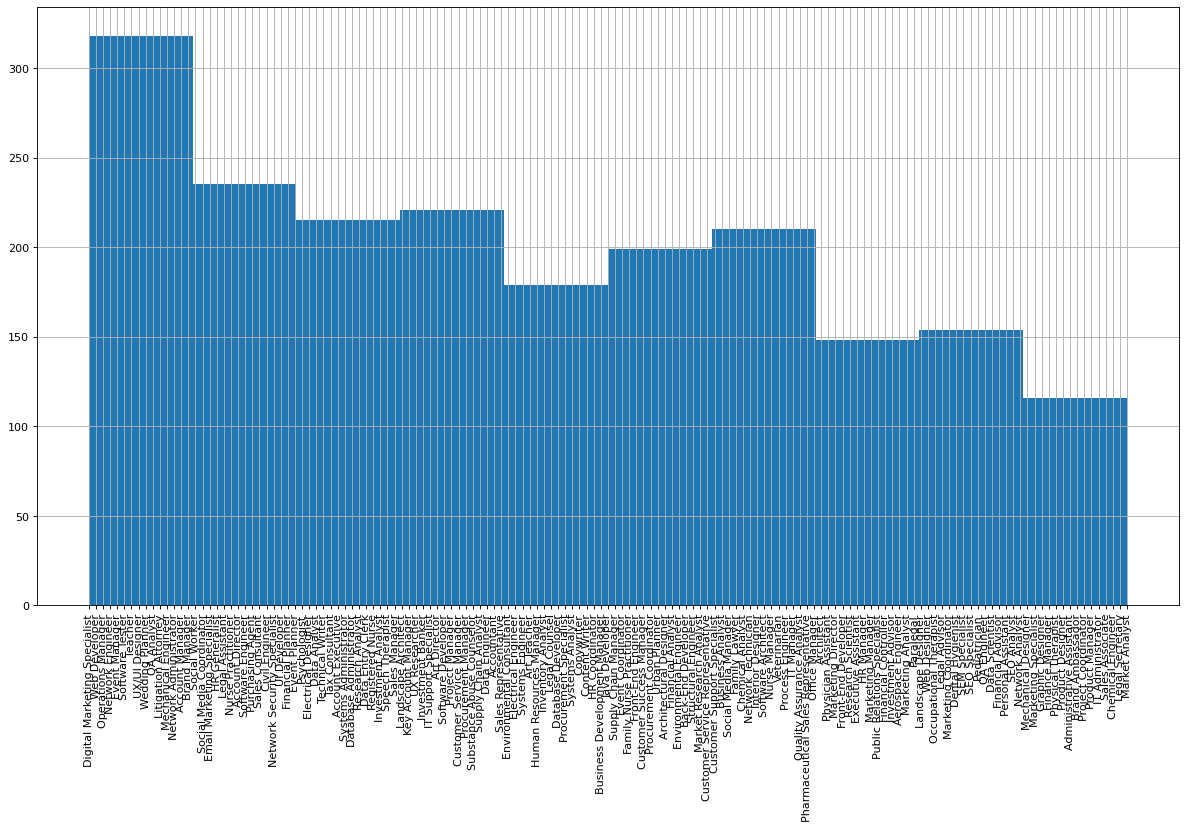

In [7]:
fig, ax = plt.subplots(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
test.Job_Title.hist(ax=ax)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [8]:
import nltk
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [9]:
## Lower case
test['Job_Description'] = test['Job_Description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
test['Job_Description'] = test['Job_Description'].str.replace('[^\w\s,]', ' ')
#test['Job_Description'] = test['Job_Description'].str.replace('[^a-zA-Z0-9\s]',' ')
## digits
test['Job_Description'] = test['Job_Description'].str.replace('\d+', '')

#remove stop words
stop = stopwords.words('english')
test['Job_Description'] = test['Job_Description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## lemmatization
test['Job_Description'] = test['Job_Description'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))


print("Preprocessed data: \n")
print(test.head())

Preprocessed data: 

                      Job_Title  \
0  Digital Marketing Specialist   
1                 Web Developer   
2            Operations Manager   
3              Network Engineer   
4                 Event Manager   

                                     Job_Description  
0  social medium manager oversee organization soc...  
1  frontend web developer design implement user i...  
2  quality control manager establish enforce qual...  
3  wireless network engineer design, implement, m...  
4  conference manager coordinate manages conferen...  


In [10]:
# Create a translation table to remove punctuation
punctuation_to_remove = string.punctuation
translation_table = str.maketrans('', '', punctuation_to_remove)

# Remove punctuation using the translation table
test['Job_Description'] = test['Job_Description'].str.translate(translation_table)
print(test.head())

                      Job_Title  \
0  Digital Marketing Specialist   
1                 Web Developer   
2            Operations Manager   
3              Network Engineer   
4                 Event Manager   

                                     Job_Description  
0  social medium manager oversee organization soc...  
1  frontend web developer design implement user i...  
2  quality control manager establish enforce qual...  
3  wireless network engineer design implement mai...  
4  conference manager coordinate manages conferen...  


In [11]:
## jda stands for job description aggregated
jda = test.groupby(['Job_Title']).sum().reset_index()
print("Aggregated job descriptions: \n")
print(jda)

Aggregated job descriptions: 

                    Job_Title  \
0            Account Director   
1           Account Executive   
2             Account Manager   
3                  Accountant   
4    Administrative Assistant   
..                        ...   
142             Urban Planner   
143              Veterinarian   
144              Web Designer   
145             Web Developer   
146           Wedding Planner   

                                       Job_Description  
0    account strategist work advertising marketing ...  
1    sale account executive responsible acquiring m...  
2    sale account manager responsible building main...  
3    financial accountant handle financial records ...  
4    support highlevel executive managing schedules...  
..                                                 ...  
142  transportation planner design manage transport...  
143  small animal veterinarian provides medical car...  
144  frontend web designer create visual element us...  
14

In [12]:
## Delete more stop words
other_stop_words = ['junior', 'senior','experience','etc','job','work','company','technique',
                    'candidate','skill','skills','language','menu','inc','new','plus','years',
                   'technology','organization','ceo','cto','account','manager','data','scientist','mobile',
                    'developer','product','revenue','strong']

test['Job_Description'] = test['Job_Description'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [14]:
## Converting text to features 
vectorizer = TfidfVectorizer()
#Tokenize and build vocabulary
X = vectorizer.fit_transform(test.Job_Description)
y = test.Job_Title

# split data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109) 
print("train data shape: ",X_train.shape)
print("test data shape: ",X_test.shape)

# Fit model
clf = MultinomialNB()
clf.fit(X_train, y_train)
## Predict
y_predicted = clf.predict(X_test)

train data shape:  (1596, 1439)
test data shape:  (399, 1439)


<Axes: >

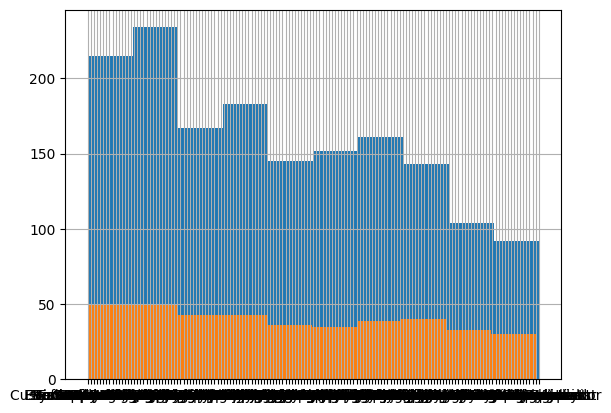

In [15]:
y_train.hist()
y_test.hist()

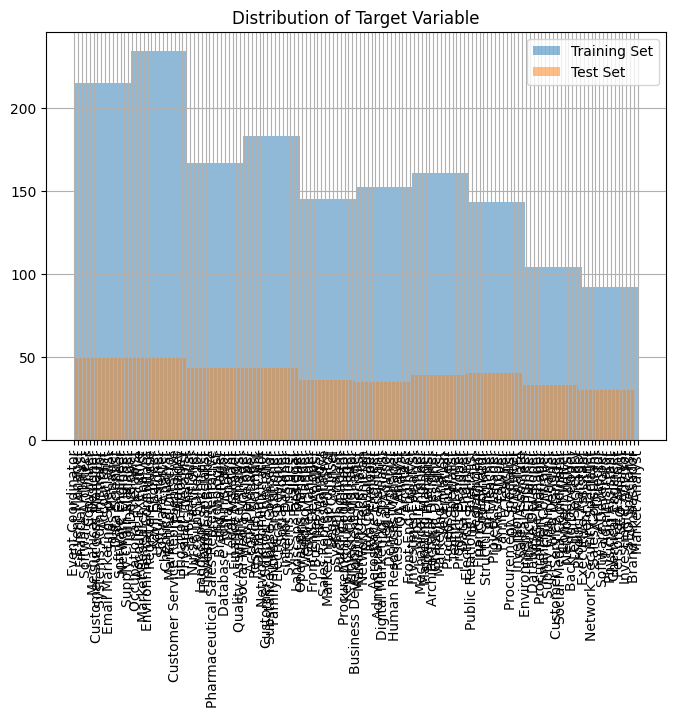

In [16]:
import matplotlib.pyplot as plt

# Plot the histograms
fig, ax = plt.subplots(figsize=(8, 6))
y_train.hist(ax=ax, alpha=0.5, label='Training Set')
y_test.hist(ax=ax, alpha=0.5, label='Test Set')

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Add a legend and title
ax.legend()
ax.set_title('Distribution of Target Variable')

# Adjust spacing to prevent label overlap
plt.subplots_adjust(bottom=0.2)

# Display the plot
plt.show()

In [17]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
#print("Classes: (to help read Confusion Matrix)\n", clf.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

Accuracy score is:  0.7543859649122807
Confusion Matrix: 
[[0 1 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Classification Report: 
                                     precision    recall  f1-score   support

                   Account Director       0.00      0.00      0.00         1
                  Account Executive       0.80      1.00      0.89         4
                    Account Manager       1.00      1.00      1.00         6
                         Accountant       1.00      1.00      1.00         1
           Administrative Assistant       1.00      0.75      0.86         4
                 Aerospace Engineer       0.00      0.00      0.00         2
                          Architect       1.00      0.33      0.50         3
             Architectural Designer       1.00      0.25      0.40         4
                       Art Director       1.00      1.00      1.00         2
                        Art

/home/veena/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/veena/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/veena/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
# Print class log prior probabilities
print("Class Log Prior Probabilities:")
print(clf.class_log_prior_)

# Print feature log probabilities
print("\nFeature Log Probabilities:")
print(np.exp(clf.feature_log_prob_))

Class Log Prior Probabilities:
[-5.58349631 -4.81030642 -4.97736051 -5.07267069 -5.07267069 -5.58349631
 -5.1780312  -5.58349631 -5.07267069 -4.97736051 -5.42934563 -5.98896142
 -4.66720558 -5.07267069 -4.73619845 -5.07267069 -5.98896142 -4.89034913
 -5.58349631 -5.07267069 -5.07267069 -5.58349631 -4.66720558 -4.33073334
 -4.81030642 -4.73619845 -4.89034913 -5.42934563 -4.54204243 -5.58349631
 -5.1780312  -4.4308168  -4.81030642 -4.97736051 -4.81030642 -4.73619845
 -5.58349631 -4.60266706 -5.76581787 -4.81030642 -4.66720558 -5.1780312
 -5.1780312  -5.42934563 -4.48488402 -4.54204243 -5.29581424 -6.6821086
 -5.42934563 -5.29581424 -4.81030642 -4.48488402 -5.98896142 -5.58349631
 -5.07267069 -7.37525578 -5.07267069 -4.73619845 -5.07267069 -5.98896142
 -5.76581787 -5.42934563 -4.60266706 -5.58349631 -5.76581787 -4.73619845
 -5.1780312  -5.07267069 -4.81030642 -4.73619845 -6.27664349 -4.60266706
 -7.37525578 -4.81030642 -5.42934563 -5.42934563 -4.89034913 -4.97736051
 -4.97736051 -4.890349